# Gas Boiler to heat pump dynamic Material Flow analysis
This doc uses the dynamic_stock_model package

The objective is to replace every boiler by heat pumps by 2050 in Vaud Canton

## Import data

In [73]:
import dynamic_stock_model as dsm 
import numpy as np
import matplotlib.pyplot as plt
import openpyxl


In [74]:
# Vaud number housing
housing_2024= 380000

# increase of the number of housing

housing_increase_2024 = 0.005

# Proportion of HP
prop_HP_2024 = 0.17
# Proportion of GB
prop_GB_2024 = 0.30

# Lifetime HP
lifetime_HP_2024 = [20]*(9+26)  # from 2015 to 2050

# Lifetime GB
lifetime_GB_2024 = [20]*(9+26)  # from 2015 to 2050

# std lifetime 
std_GB=0.25
std_HP=0.25
# density functions
HP_pdf='Normal'
GB_pdf='Normal'

# Define time range
Years = np.arange(2015, 2051) # 2015 to 2025 is the initialisation then 2025 to 2050 is the projection



## Initial parameters


In [75]:
# Use previous import of HP and GB sales
GB_sales =[1]*10+[0]*26

## Create the models

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 36 years.<br>Inflow vector is present with 36 years.<br>Total stock is present with 36 years.<br>Stock by cohorts is present with 36 years and 36 cohorts.<br>Total outflow is not present.<br>Outflow by cohorts is not present.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20].<br>', 1)


Text(0, 0.5, 'Number of Gas Boilers')

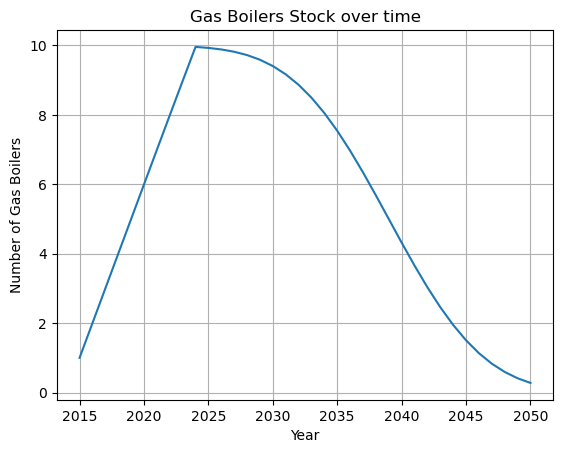

In [76]:
# inflow driven model for Gas boilers
GB_DSM = dsm.DynamicStockModel(t = Years, 
                               i =GB_sales, lt = {'Type': GB_pdf, 'Mean': lifetime_GB_2024, 'StdDev': std_GB* np.array(lifetime_GB_2024)},)

# compute stock
S_C, O_C= GB_DSM.compute_s_c_inflow_driven()

S=GB_DSM.compute_stock_total()
check_GB=GB_DSM.dimension_check()
# plot stock
print(check_GB)
plt.grid()
plt.plot( GB_DSM.t,GB_DSM.s, label='Gas Boilers Stock')
plt.title('Gas Boilers Stock over time')
plt.xlabel('Year')
plt.ylabel('Number of Gas Boilers')


In [77]:
# Model for the heat pumps
HP_sales = [1]*10+ GB_DSM.s.tolist()[10:]  # from 2015 to 2025 is the initialisation then 2025 to 2050 is the projection
HP_DSM = dsm.DynamicStockModel(t = Years, 
                               i =HP_sales, lt = {'Type': HP_pdf, 'Mean': lifetime_HP_2024, 'StdDev': std_HP* np.array(lifetime_HP_2024)},)

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 36 years.<br>Inflow vector is present with 36 years.<br>Total stock is present with 36 years.<br>Stock by cohorts is present with 36 years and 36 cohorts.<br>Total outflow is not present.<br>Outflow by cohorts is not present.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20].<br>', 1)


Text(0, 0.5, 'Number of Gas Boilers')

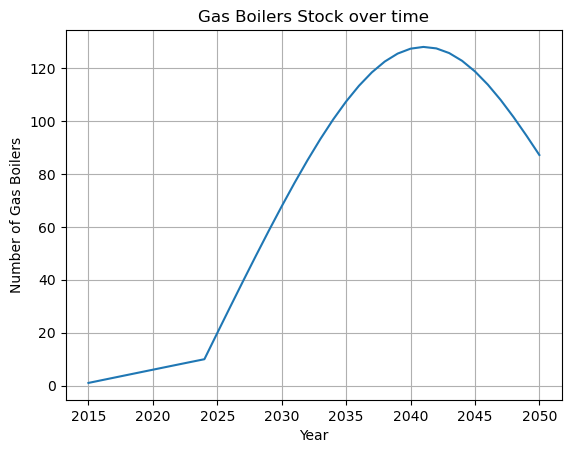

In [78]:
# compute stock
S_C1, O_C1= HP_DSM.compute_s_c_inflow_driven()

S1=HP_DSM.compute_stock_total()
check_HP=HP_DSM.dimension_check()
# plot stock
print(check_HP)
plt.grid()
plt.plot( HP_DSM.t,HP_DSM.s, label='Gas Boilers Stock')
plt.title('Gas Boilers Stock over time')
plt.xlabel('Year')
plt.ylabel('Number of Gas Boilers')

## Sensitivity analysis